In [1]:
import numpy as np
import pandas as pd
import os
from random import choice, sample, randint
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split
from shutil import copyfile

In [2]:
import tensorflow as tf

from tensorflow.python.keras import backend
from tensorflow.keras import layers, Model

In [3]:
from utils import visualize

IndentationError: unindent does not match any outer indentation level (utils.py, line 1232)

In [49]:
class Linear(layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [3]:
def dense_block(x, blocks, name):
    """
    A dense block
  
    Input:
        - x: input tensor.
        - blocks: integer, the number of building blocks.
        - name: string, block label.
      Output:
        - tensor for the block.
    """

    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    """
    A transition block
  
    Input:
        - x: input tensor.
        - reduction: float, compression rate at transition layers.
        - name: string, block label.
      Output:
        - tensor for the block.
    """
    
    bn_axis = 4 if backend.image_data_format() == 'channels_last' else 1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv3D(int(backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = layers.AveragePooling3D(1, strides=(2,2,2), name=name + '_pool')(x)
    return x


def conv_block(x, growth_rate, name):
    """
    A building convolutional block for a dense block
  
    Input:
        - x: input tensor.
        - growth_rate: float, growth rate at dense layers.
        - name: string, block label.
      Output:
        - tensor for the block.
    """
    
    bn_axis = 4 if backend.image_data_format() == 'channels_last' else 1
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv3D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv3D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    
    return x


In [69]:
class DensenetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs):
        print('original input shape:', input_shape)
        if len(input_shape) != 4:
            raise Exception("Input shape should be a tuple (nb_channels, kernel_dim1, kernel_dim2, kernel_dim3)")

        print('original input shape:', input_shape)
        # orignal input shape: (4,80,80,80)

        if backend.image_data_format() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[3], input_shape[0])
        #input_shape = (input_shape[1], input_shape[2], input_shape[3], input_shape[0])
        print('change input shape:', input_shape)

        input_0 = layers.Input(shape=input_shape)

        # 3D Convolution and pooling
        conv1 = layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='SAME', kernel_initializer='he_normal')(input_0)
        pool1 = layers.MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2))(conv1)

        # Dense Block1
        x = dense_block(pool1, 6, name='conv1')
        x = transition_block(x, 0.5, name='pool1')
        x = dense_block(x, 6, name='conv2')
        x = transition_block(x, 0.5, name='pool2')
        x = dense_block(x, 6, name='conv3')
        print(x.shape)
        x = layers.GlobalAveragePooling3D(name='avg_pool')(x)
        print(x.shape)

        # Classifier block
        output = layers.Dense(units=476, activation="softmax", kernel_initializer="he_normal")(x)
        #output = tf.compat.v1.layers.Linear(x.shape[1], 21)(x)
        model = Model(inputs=input_0, outputs=output)
        return model

    @staticmethod
    def build_densenet(input_shape, num_outputs):
        #(n_channeles, box_size, box_size, box_size); (seq_len, alphabet_len)
        #             |||
        # (4, 80, 80, 80); (501, 21)
        return DensenetBuilder.build(input_shape, num_outputs)

In [9]:
def get_batches(X, y, batch_size):
    n_samples = len(X)
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], y[batch_idx] 
        
def get_sample(dir_npy, dir_seq, draw = False):
    
    files_all = list(filter(lambda x: x.endswith('.npy'), os.listdir(dir_npy)))
    
    file_sample = choice(files_all)
    print(file_sample)
    with open(dir_npy + '/' + file_sample, 'rb') as f_1:
            X = np.load(f_1)
    with open(dir_seq + '/pdb' + file_sample[0:-4] + '_seq.npy', 'rb') as f_2:
            y = np.load(f_2)
    f_1.close()
    f_2.close()
    
    print('Shape of X:', X.shape)
    print('Shape of y:', y.shape)
    print()
    
    #if draw:
        #visualize(dir_npy, file_sample, 3, True)
    
    
    return(X, y, X.shape, y.shape)

In [7]:
dir_npy = './data'
dir_seq = './SEQs'

files_1 = list(filter(lambda x: x.endswith('.npy'), os.listdir(dir_npy)))
files_2 = list(filter(lambda x: x.endswith('.npy'), os.listdir(dir_seq)))

print(len(files_1), len(files_2))
k = 0
file_list1 = []
file_list2 = []

for file in files_1:
    if ('pdb' + file[0:-4] + '_seq.npy' in files_2):
        file_list1.append(file)

for file in files_2:
    if (file[3:-8] + '.npy' in files_1):
        file_list2.append(file)
    else:
        k+=1
      

30604 31742


KeyboardInterrupt: 

In [6]:
dir_seq = './SEQs'

files_2 = list(filter(lambda x: x.endswith('.npy'), os.listdir(dir_seq)))
files_2[0]

'pdb2gtb_seq.npy'

In [34]:
with open('files_final_list.txt', 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)

In [12]:
dir_X = './X'
try:
    os.mkdir(dir_X)
    print("Directory " , dir_X ,  " Created ") 
except FileExistsError:
    print("Directory " , dir_X ,  " already exists")
    
dir_y = './y'
try:
    os.mkdir(dir_y)
    print("Directory " , dir_y ,  " Created ") 
except FileExistsError:
    print("Directory " , dir_y ,  " already exists")

Directory  ./X  already exists
Directory  ./y  already exists


In [86]:
for i, file_X in enumerate(files_1):
    
    if file_X in file_list:
        copyfile(dir_npy + '/' + file_X, dir_X + '/' + file_X)

In [87]:
for i, file_y in enumerate(files_2):
    
    if file_y[3:-8] + '.npy' in file_list:
        copyfile(dir_seq + '/' + file_y, dir_y + '/seq_' + file_y[3:-8] + '.npy')

In [42]:
dir_npy = './set'
dir_seq = './SEQs'

X, y, X_shape, y_shape = get_sample(dir_npy, dir_seq, True)

4wts.npy
Shape of X: (4, 80, 80, 80)
Shape of y: (476, 21)



In [66]:
model = DensenetBuilder.build_densenet(X_shape, y_shape)
model.compile(loss="categorical_crossentropy", optimizer="sgd")
model.optimizer.learning_rate.assign(0.01)

original input shape: (4, 80, 80, 80)
original input shape: (4, 80, 80, 80)
change input shape: (80, 80, 80, 4)
(None, 10, 10, 10, 352)
(None, 352)


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.01>

In [13]:
file_names = list(filter(lambda x: x.endswith('.npy'), os.listdir('set')))
assert len(file_names) == len(list(filter(lambda x: x.endswith('.npy'), os.listdir('SEQs'))))

In [15]:
X_list = []
y_list = []

for idx, file in enumerate(file_names):
    X_list.append(np.load('./set/' + file))

    y_list.append(np.load('./SEQs/pdb' + file[0:-4] + '_seq.npy'))
    


In [16]:
train_test_split = 0.8

X_train = X_list[:int(train_test_split*len(X_list))]
X_test = X_list[int(train_test_split*len(X_list)):]

print(len(X_train), len(X_test))

y_train = y_list[:int(train_test_split*len(y_list))]
y_test = y_list[int(train_test_split*len(y_list)):]

print(len(y_train), len(y_test))

40 10
40 10


In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [18]:
batch_size = 100
train_dataset = train_dataset.shuffle(1000).repeat().batch(batch_size)

In [75]:
model = DensenetBuilder.build_densenet(X_shape, y_shape)
model.compile(loss="categorical_crossentropy", optimizer="sgd")
model.optimizer.learning_rate.assign(0.01)
#tf.nn.softmax_cross_entropy_with_logits
#model.summary()



original input shape: (4, 80, 80, 80)
original input shape: (4, 80, 80, 80)
change input shape: (4, 80, 80, 80)
(None, 1, 10, 10, 352)
(None, 352)


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.01>

In [86]:
def reverse_encoding(y_list):
    alphabet = ['\n', 'A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    z = []
    for y in y_list:
        z_ = []
        for a in y:
            for i, y_i in enumerate(a):
                if y_i == 1:
                    z_.append(alphabet[i])
        z.append(z_)
                
    return z

In [96]:
y_tr_n = reverse_encoding(y_train)
y_te_n = reverse_encoding(y_test)
train_dataset_n = tf.data.Dataset.from_tensor_slices((X_train, y_tr_n))


ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [76]:
history = model.fit_generator(
    generator = train_dataset,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    steps_per_epoch=10, 
    validation_data=(X_test, y_te_n),
)

Epoch 1/2


ValueError: in user code:

    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/alexh3/anaconda3/envs/res/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 476, 21) and (None, 476) are incompatible


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from tensorflow.keras.utils import to_categorical

In [38]:
#conv1 = layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='SAME', kernel_initializer='he_normal')(input_0)
#pool1 = layers.MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2))(conv1)
no_classes = 21

model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_normal', input_shape=X_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(501, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(no_classes, activation='softmax'))

In [101]:
N_train = 2
N_test = 4
rotations = False
N_epochs = 200

#  написать генератор батчей, энкодинг меток

### Plot some examples

In [8]:
def plot_and_save(dir_npy, dir_pic, N_iter):

    '''
    Voxelization via moleculekit library, pretty straightforward, but all errors are handled, messages and broken files are put into log message file

    Input: 
        - dir_npy: directory with npy files 
        - entry: pdb entry for voxelization visualization, default - random entry out of dir_npy folder 
        - channel: channel to voxelize, default - occupancy
        - visualize_all: boolean variable that indicates whether you whant to visualize all channeles or one particular, default - True

    Output:
        None
    '''
    try:
        os.mkdir(dir_pic)
        print("Directory " , dir_pic ,  " Created ")
    except FileExistsError:
        print("Directory " , dir_pic ,  " already exists")
        
    files_npy = sample(os.listdir(dir_npy), N_iter)
    color_list = ['r', 'g', 'b', 'y']
    
    for file in files_npy:
        
        with open(dir_npy + '/' + file, 'rb') as f:
                channeles = np.load(f)
                
        for ch in range(4):
            fig = plt.figure(figsize=(14, 14))
            ax = fig.gca(projection='3d')
            ax.voxels(channeles[ch], facecolors=color_list[ch], edgecolor='k')

            plt.savefig(dir_pic + '/' + file + '_channel_' + str(ch) + '.png')

           
        fig = plt.figure(figsize=(9, 9))
        ax = fig.gca(projection='3d')
        ax.voxels(channeles[0], facecolors='r', edgecolor='k')
        ax.voxels(channeles[1], facecolors='g', edgecolor='k')       
        ax.voxels(channeles[2], facecolors='b', edgecolor='k')
        
        plt.savefig(dir_pic + '/' + file + '_all channels' + '.png')
        
    


Directory  ./pics  already exists


/home/anaconda3/envs/moleculekit/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


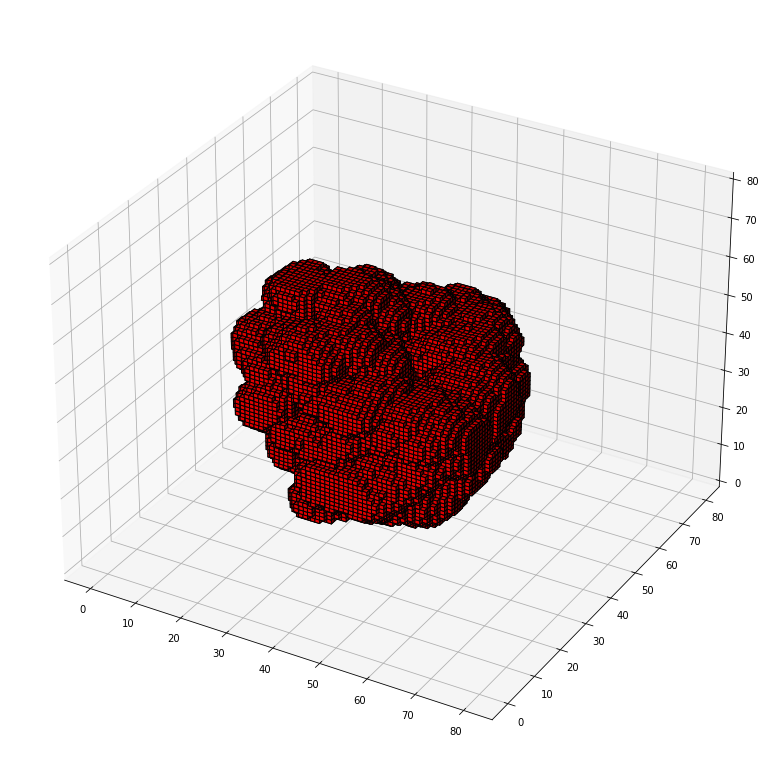

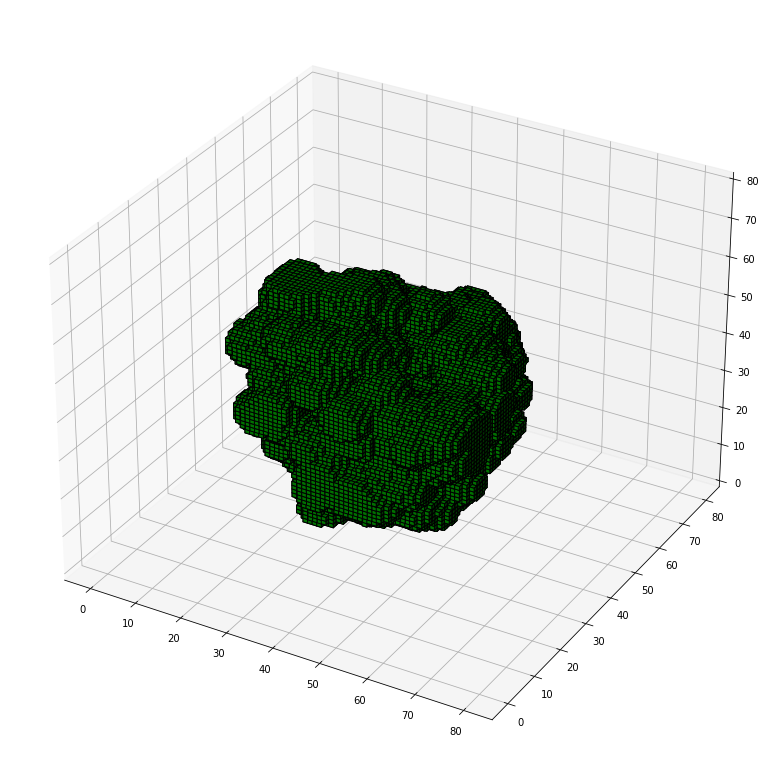

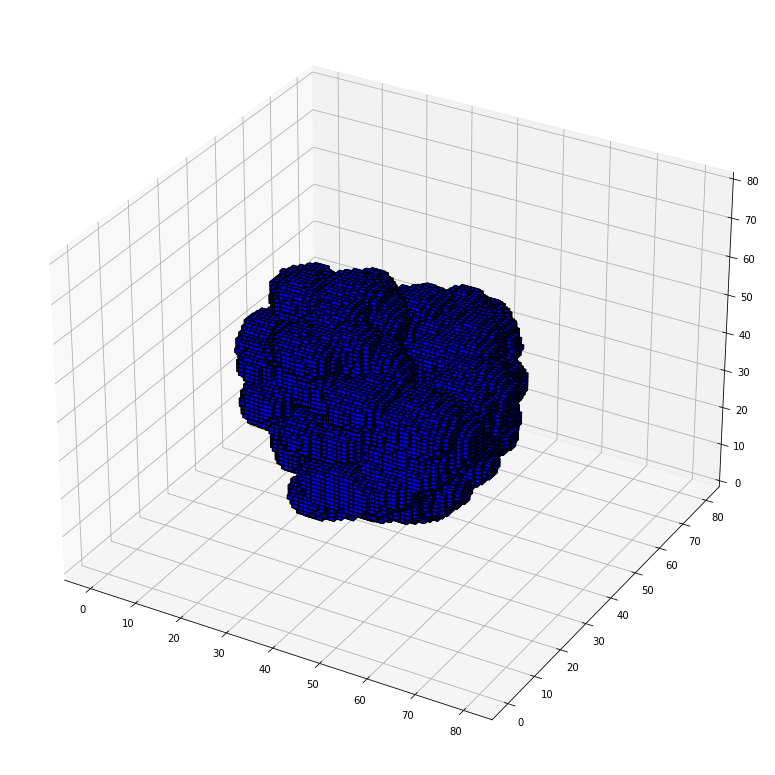

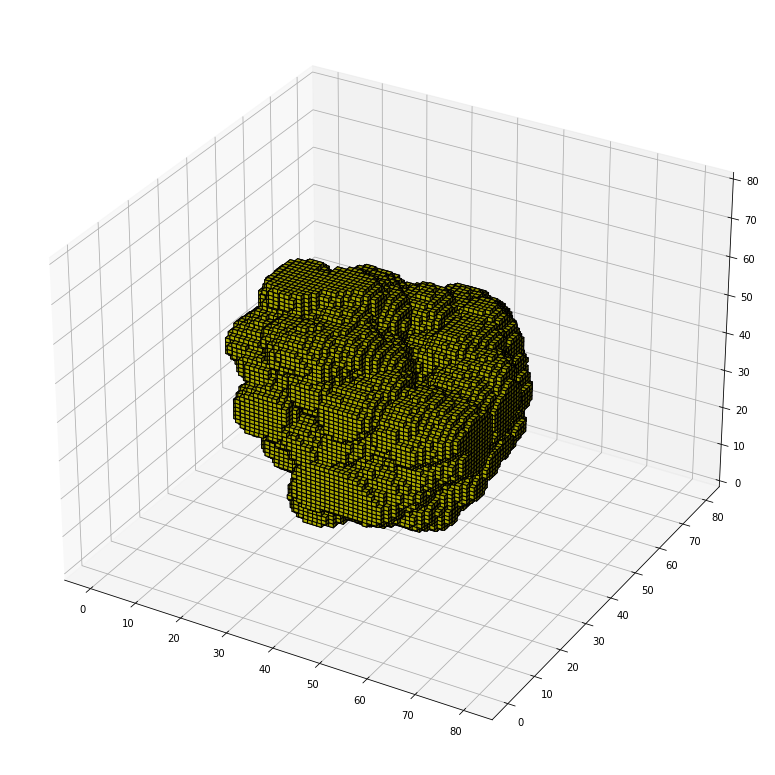

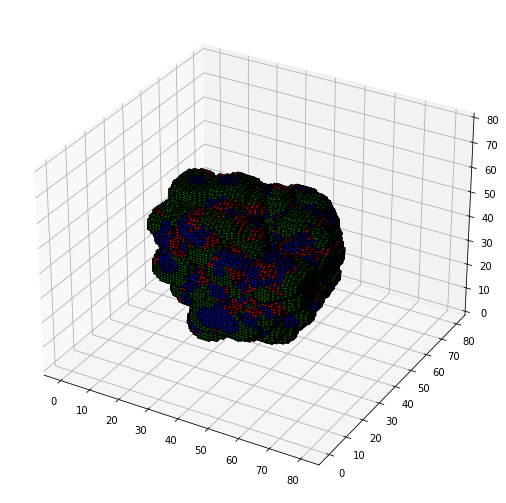

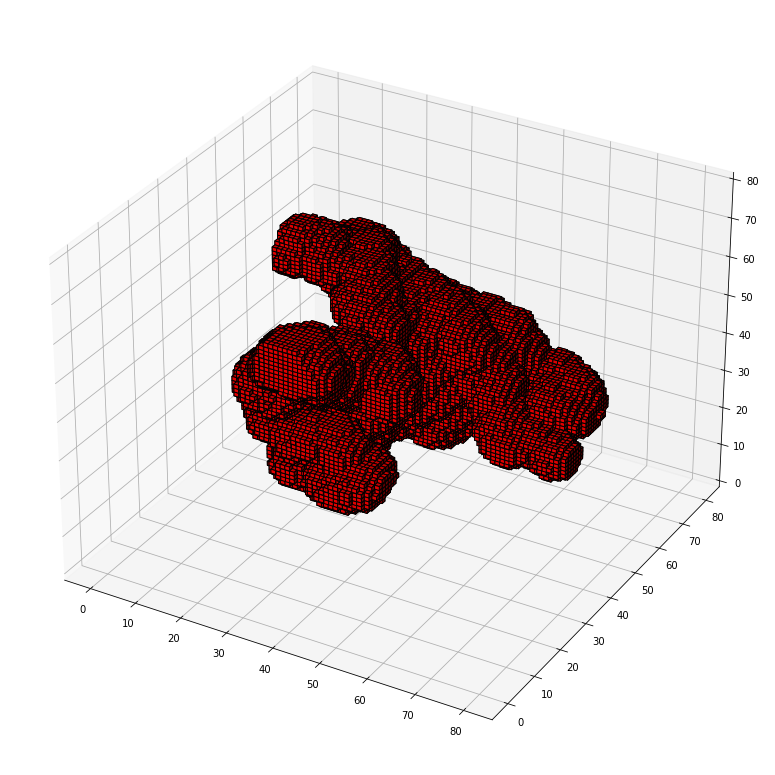

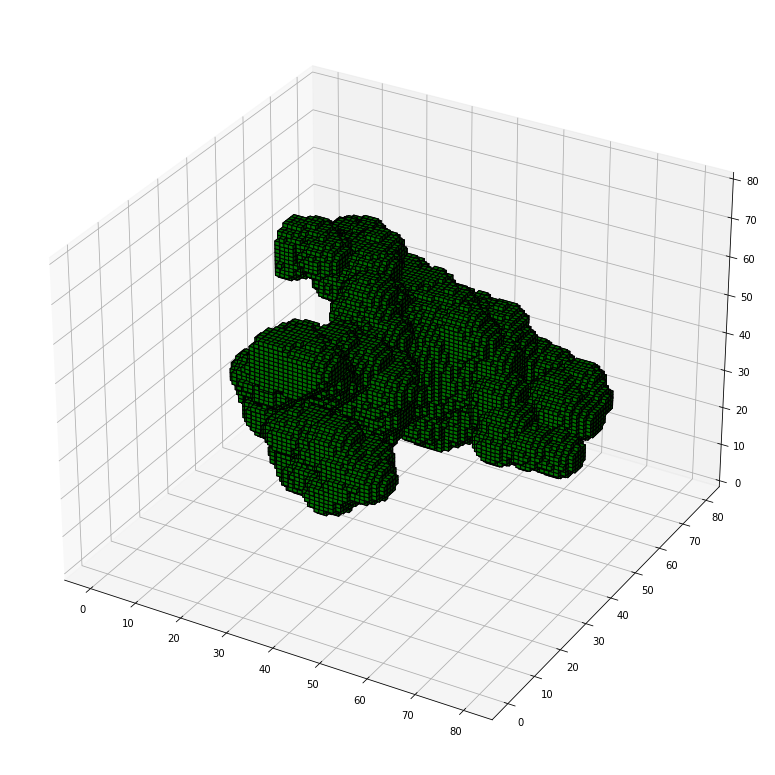

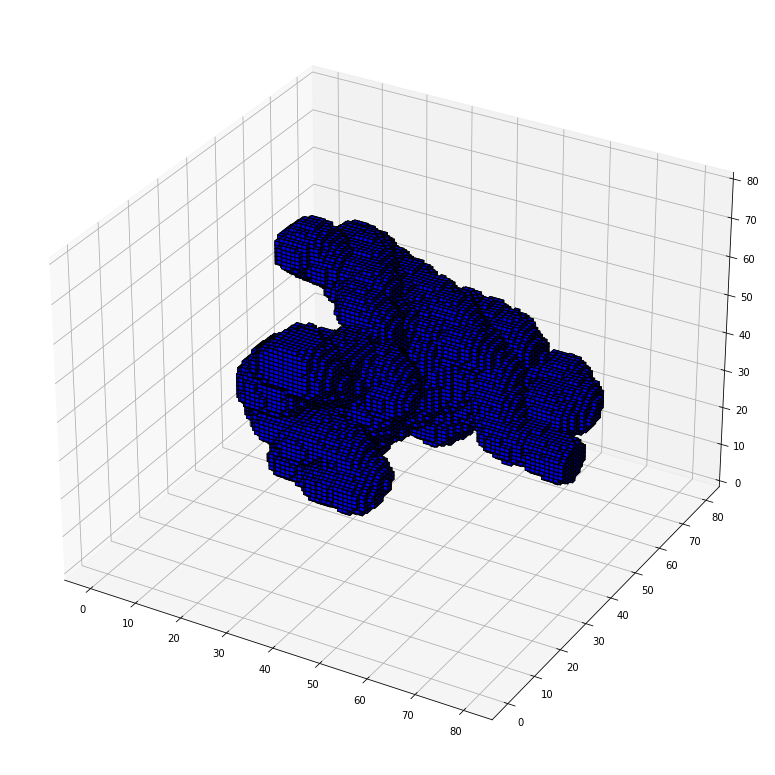

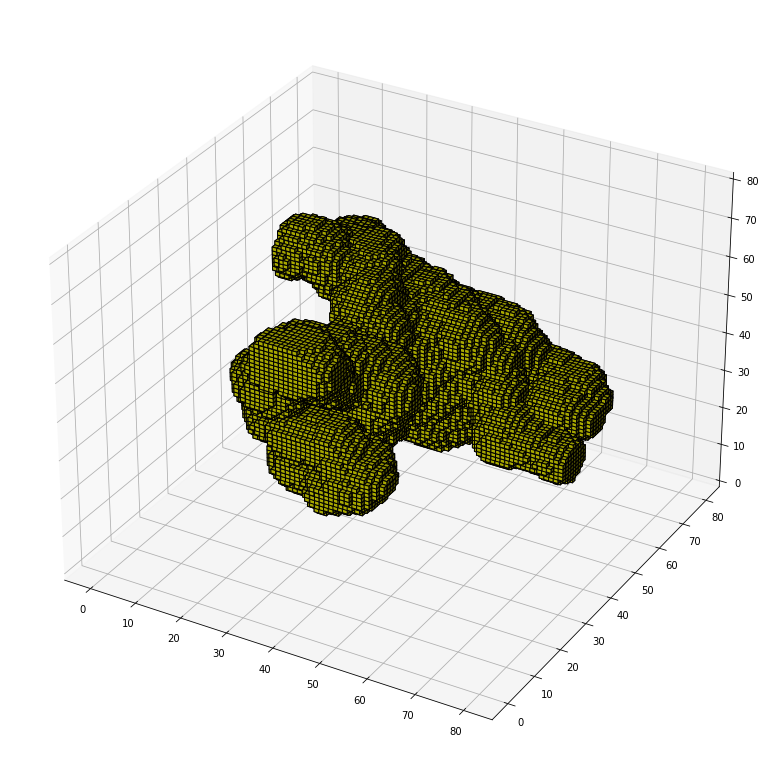

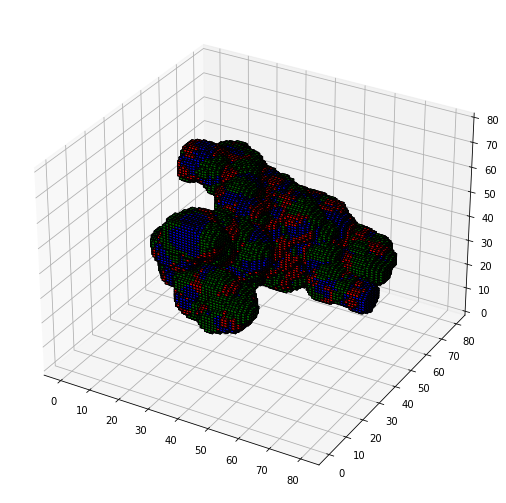

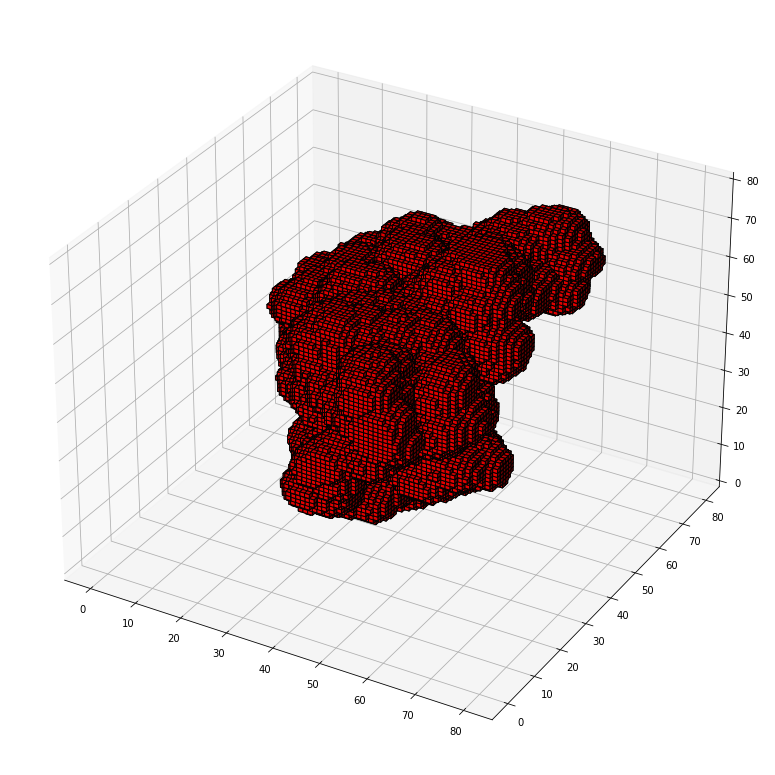

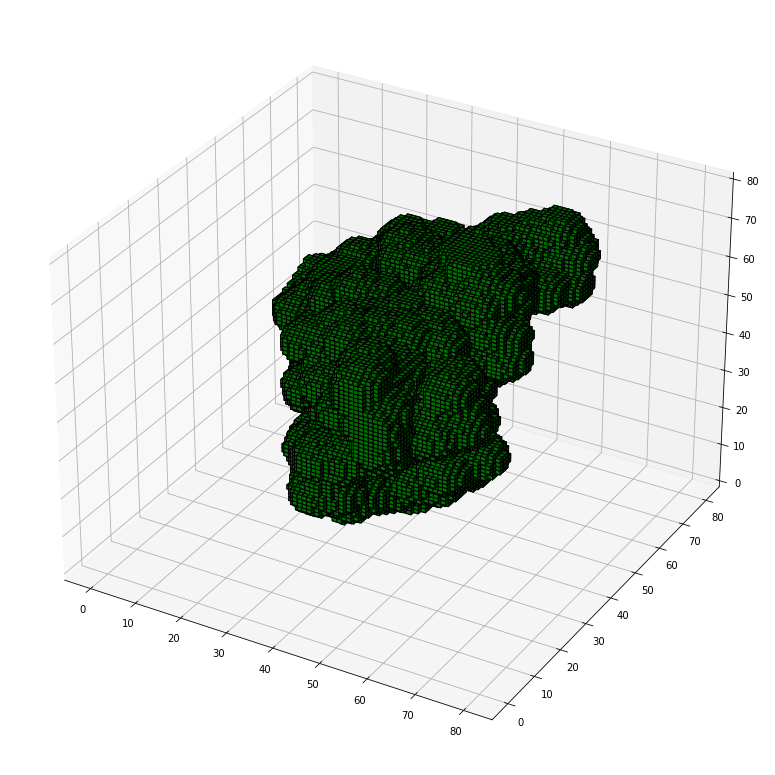

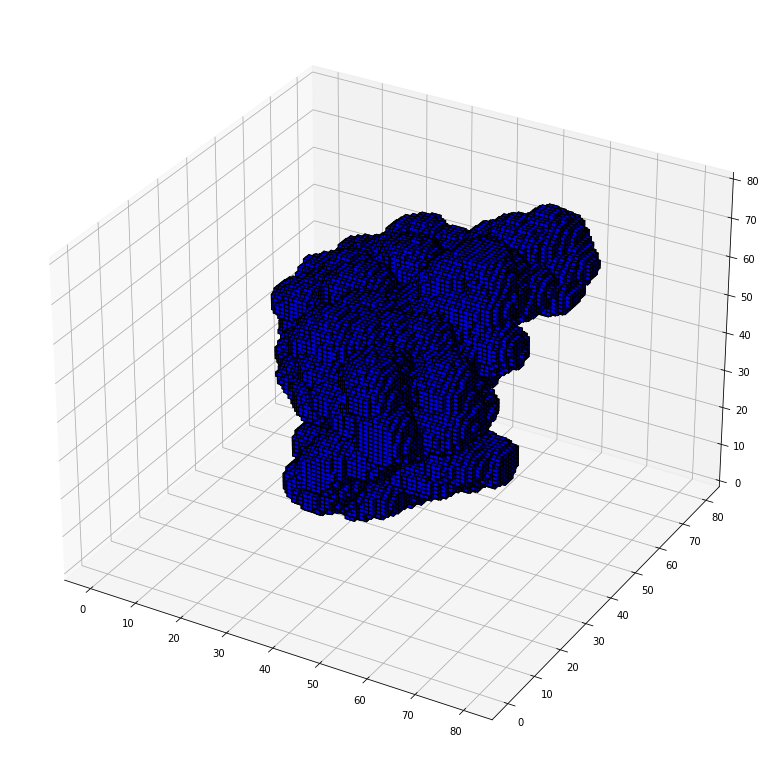

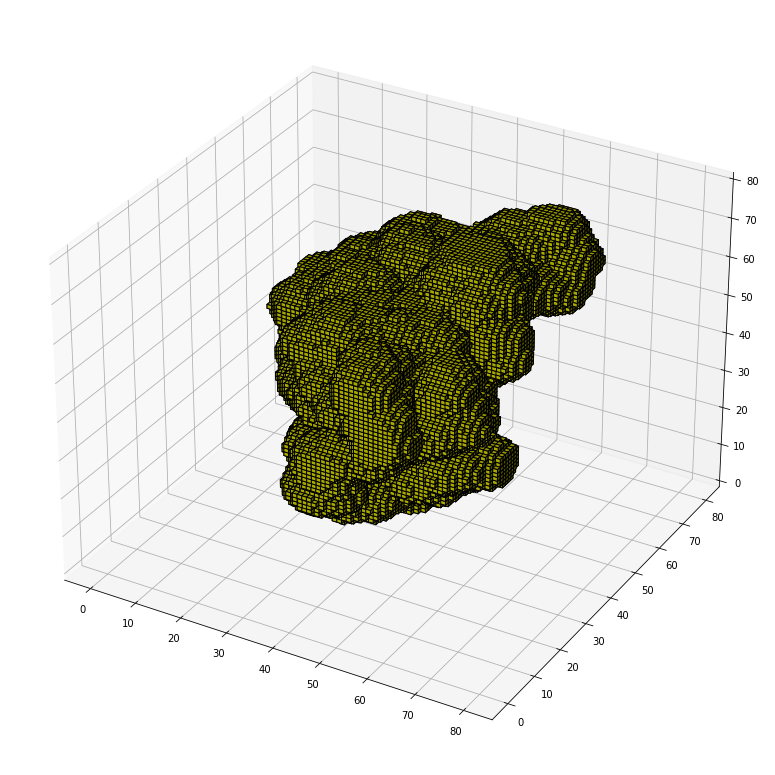

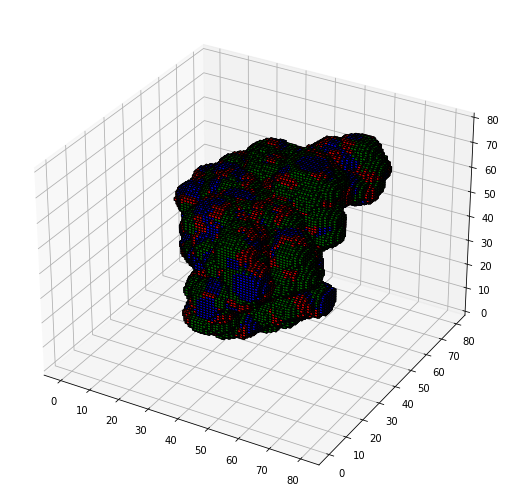

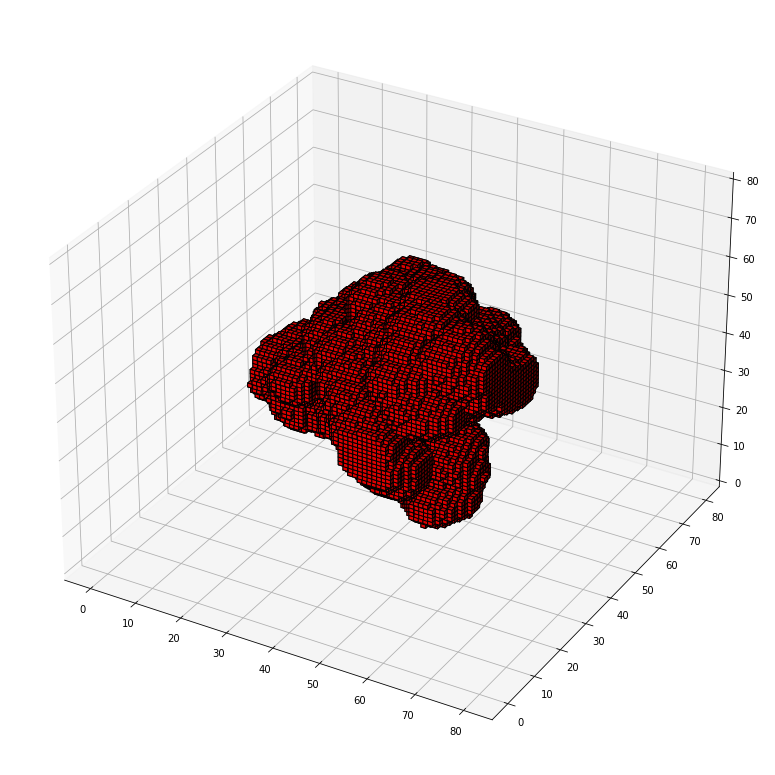

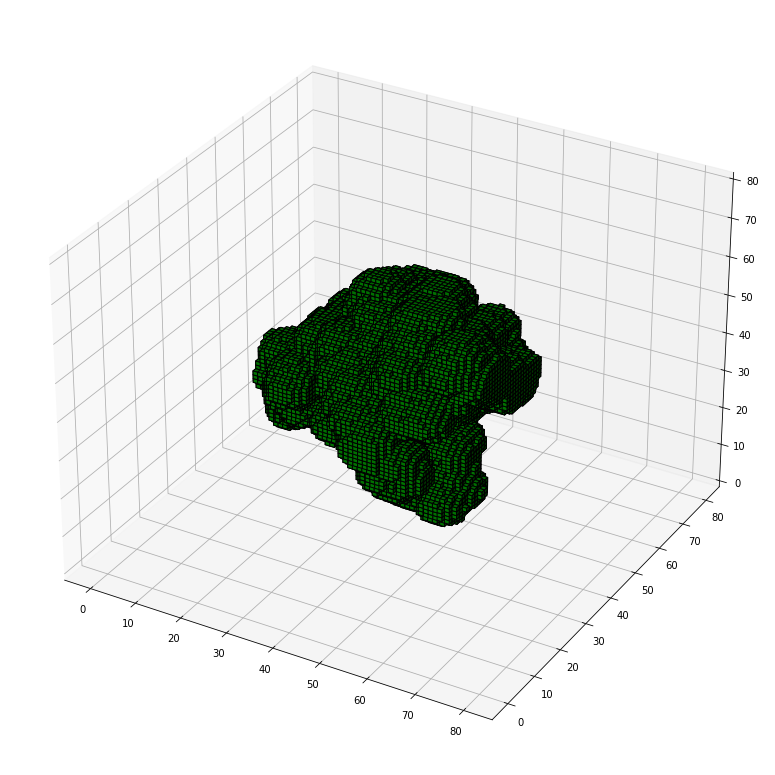

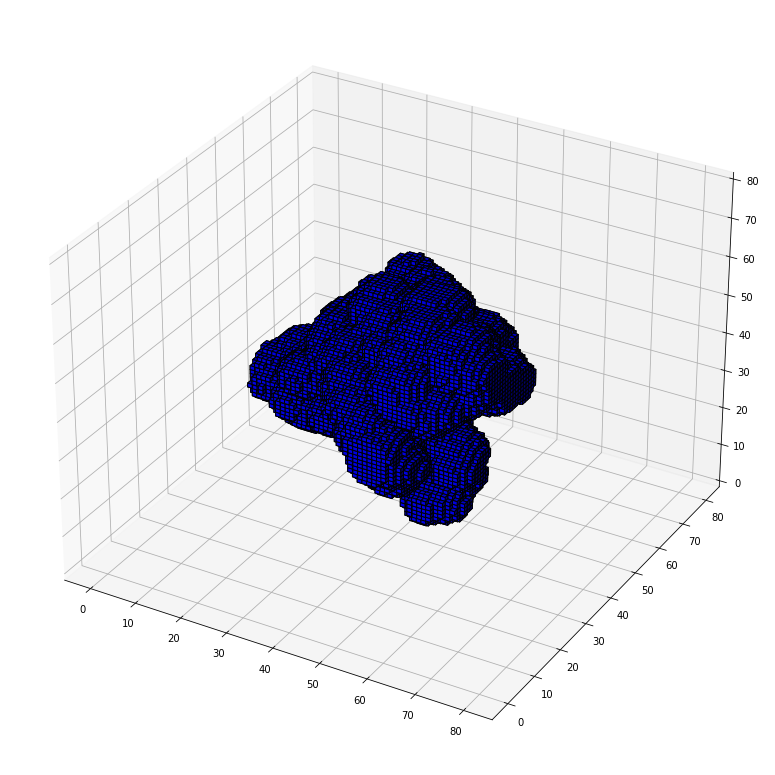

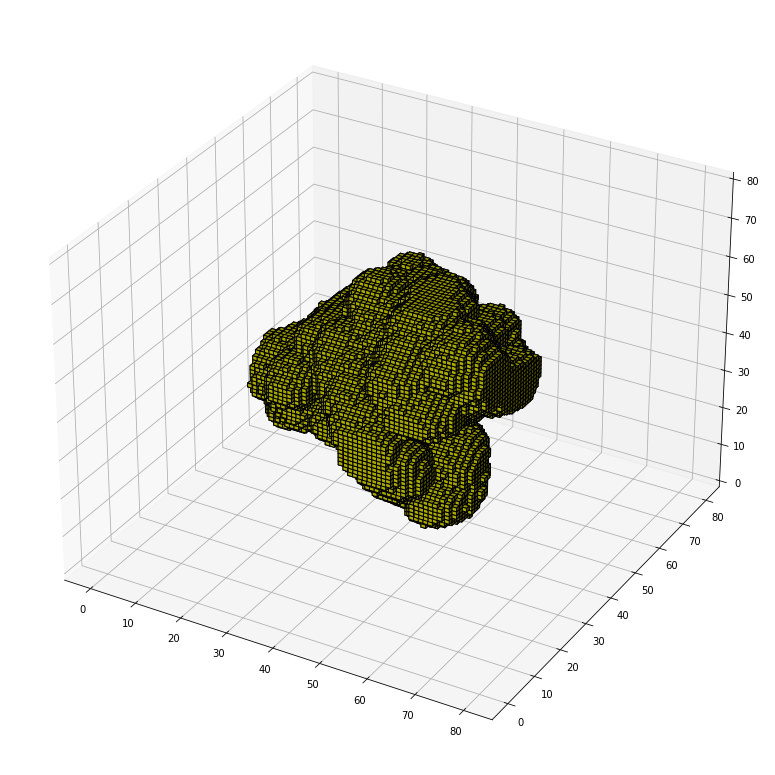

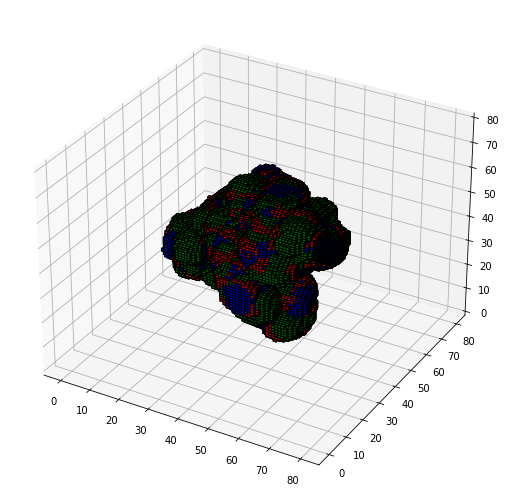

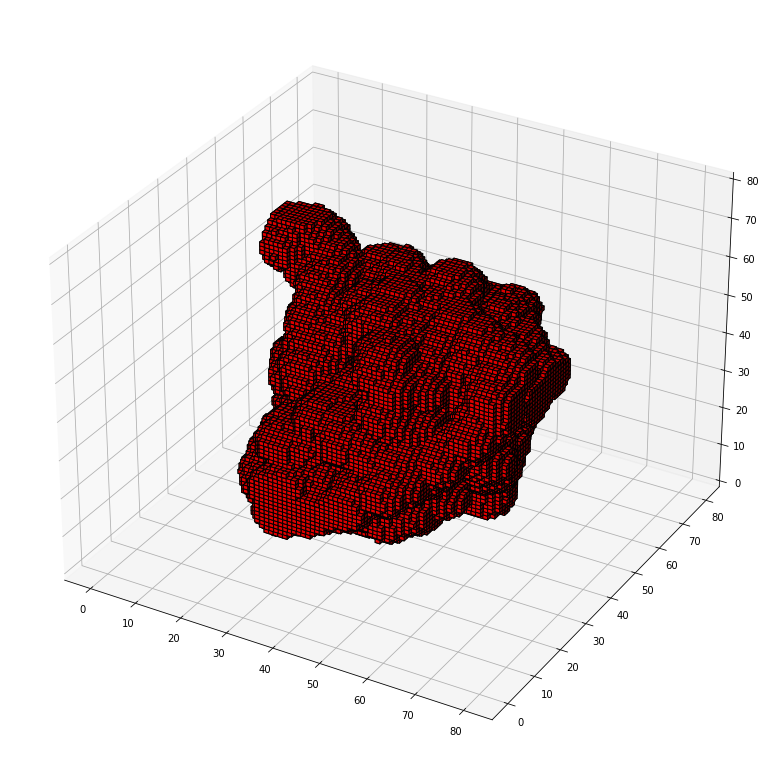

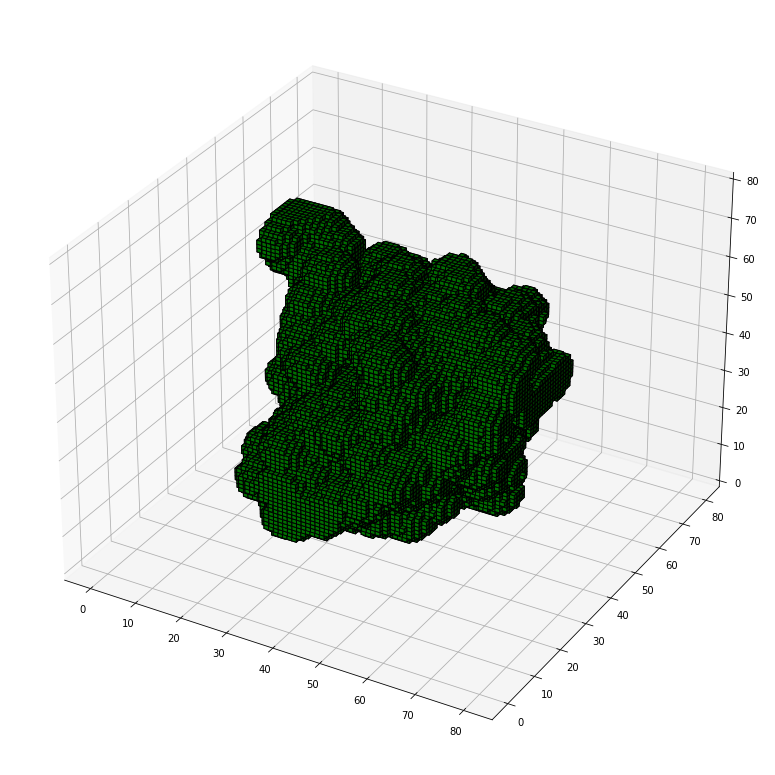

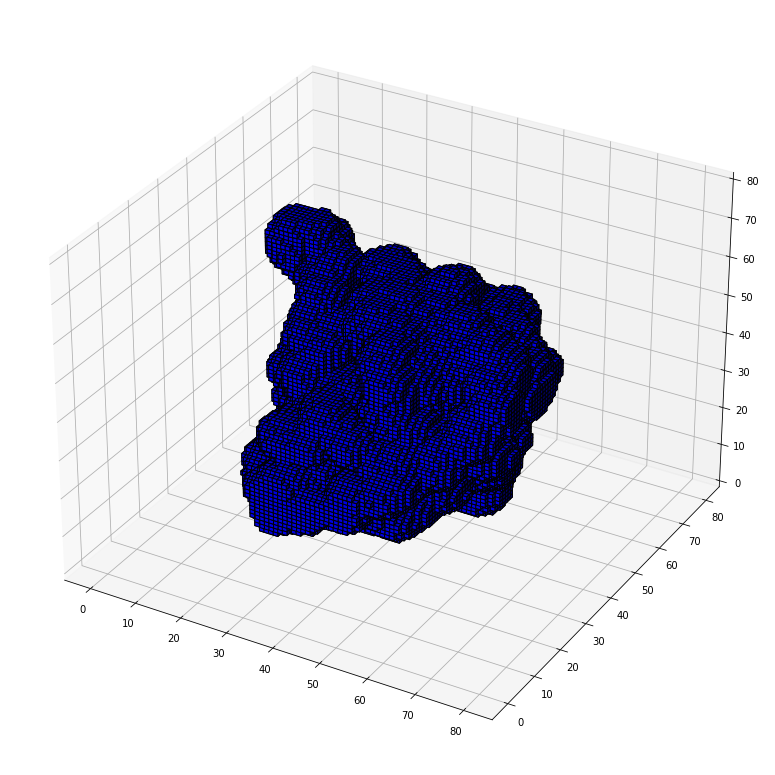

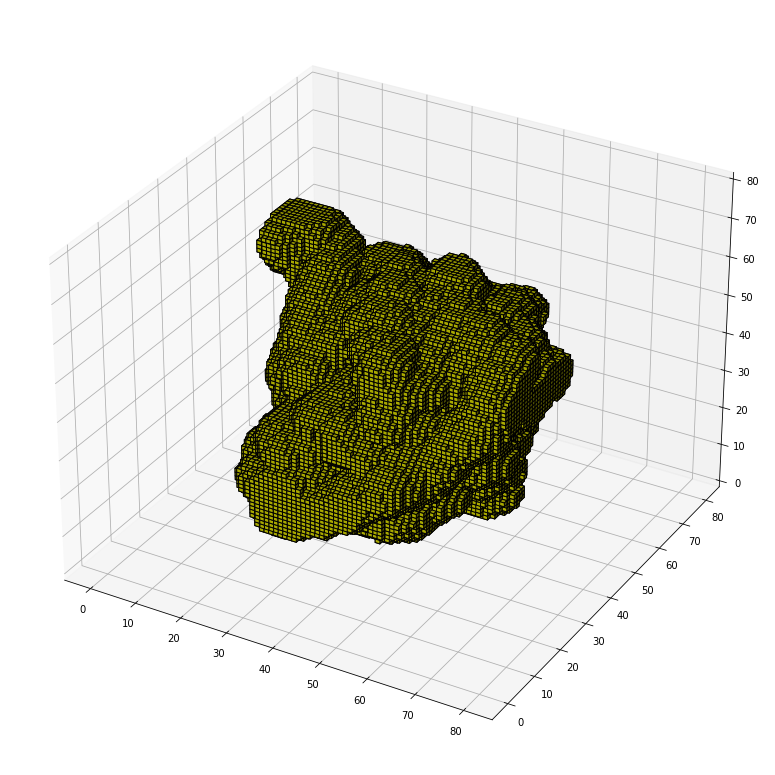

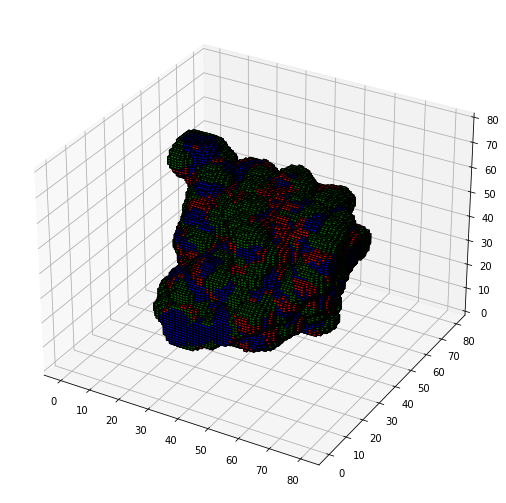

In [9]:
plot_and_save('./data', './pics', 5)